# Is Alresford a 15 minute town?

***1 October 2020***

This study is in two parts and is adapted from these two notebooks by Geoff Boeing:

- https://github.com/gboeing/network-clustering/blob/master/network-clustering-simple.ipynb
- https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb

## 0. Imports

In [1]:
import osmnx as ox
import pandas as pd
import networkx as nx
import contextily as cx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import itertools
#import numpy as np

from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix

from networkx.algorithms import approximation as approx

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.0'

## 1. Identifying the town centre/centres

- get the boundary of the town (buffered by 100m)
- get the driveable street network within the town boundary
- get shop geometries from OpenStreetMap
- convert all shop geometries to centroid points

In [2]:
# Geocode Alresford to its boundary and buffer by 100m
study_boundary = ox.geocode_to_gdf('New Alresford, Hampshire', buffer_dist=100)
# Also tested on Petersfield
#study_boundary = ox.geocode_to_gdf('Petersfield, Hampshire', buffer_dist=100)

We'll work with an undirected driveable network.
- It is undirected on the basis that the analysis is for walking - one way streets are not relevant.
- It is driveable on the basis that even though there are some pedestrian shortcuts available they may not be desirable.

In [3]:
# Get the driveable street network
G = ox.graph_from_polygon(study_boundary['geometry'].values[0],
                          network_type='drive')
# Convert it to undirected
G_un = ox.get_undirected(G)

In [4]:
# Use OSMnx to get 'shop' OSM geometries for Alresford as a geodataframe
pois = ox.geometries_from_polygon(study_boundary['geometry'].values[0],
                                   tags={'shop': True})

# reduce the columns in the dataframe to the minimum necessary
pois = pois [['unique_id', 'name', 'shop', 'geometry']]

# shops on OSM can be any kind of geometry (point, linestring, polygon)
# write the x,y coordinates of the shops into individual columns
# Note: this leaves the original geometry intact
pois['x'] = pois.geometry.centroid.x
pois['y'] = pois.geometry.centroid.y

pois.head(2)

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()
/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':


,unique_id,name,shop,geometry,x,y
0,node/938735080,Alresford Cycles,bicycle,POINT (-1.16210 51.09011),-1.162100,51.090107
1,node/4279895977,Sole Butchers,butcher,POINT (-1.16162 51.09074),-1.161622,51.090742


In [5]:
# Use OSMnx to get 'building' OSM geometries for Alresford as a geodataframe
buildings = ox.geometries_from_polygon(study_boundary['geometry'].values[0],
                                       tags={'building': True})

# reduce the columns in the dataframe to the minimum necessary
buildings = buildings[['unique_id', 'geometry']]
# exclude non-polygonal geometries - this avoids an issue with coloring geopandas plots
buildings = buildings[buildings['geometry'].geom_type.isin(['Polygon', 'MultiPolygon'])]

# write the x,y coordinates of the shops into individual columns
# Note: this leaves the original geometry intact
buildings['x'] = buildings.geometry.centroid.x
buildings['y'] = buildings.geometry.centroid.y

buildings.head(2)

/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':
/home/nick/anaconda3/envs/atelierlibre/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]


,unique_id,geometry,x,y
1,way/118242839,"POLYGON ((-1.16696 51.09445, -1.16686 51.09447...",-1.166875,51.094393
2,way/179053864,"POLYGON ((-1.16136 51.09019, -1.16122 51.09023...",-1.161139,51.090165


#### Show the network and POIs

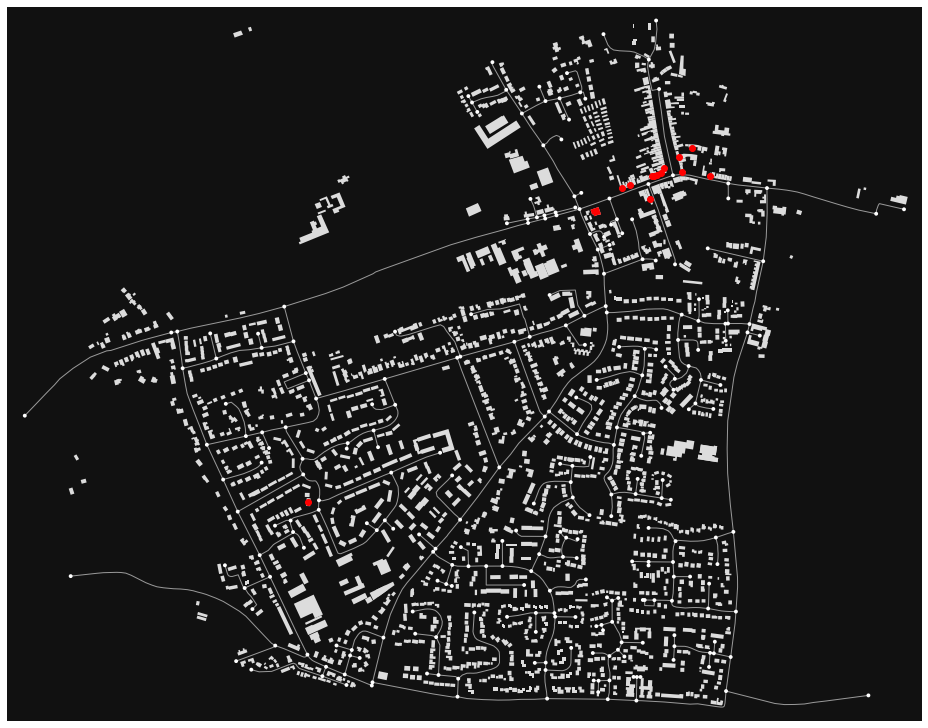

In [6]:
# plot the graph with shops overlaid
fig, ax = ox.plot_graph(G_un, figsize=(13,13),
                        show=False,
                        close=False)
pois.plot(ax=ax,
          color='red',
          zorder=2)
buildings.plot(ax=ax,
               color='gainsboro')
fig.tight_layout()
fig.savefig('New_Alresford_network_buildings_pois.png', facecolor='k')

## 1.2 Identify clusters

1. Add the nearest network node id to every POI
2. Create a distance matrix between the relevant network nodes
3. Cluster the network nodes using the distance matrix
4. Join the node cluster ids to the POIs

### 1.2.1 Add the nearest network node id to every POI

In [7]:
# attach nearest network node to each firm
pois['nearest_node'] = ox.get_nearest_nodes(G_un,
                                             X=pois['x'],
                                             Y=pois['y'],
                                             method='balltree')
print("Number of POIs:", len(pois))
pois.head(2)

Number of POIs: 14


,unique_id,name,shop,geometry,x,y,nearest_node
0,node/938735080,Alresford Cycles,bicycle,POINT (-1.16210 51.09011),-1.162100,51.090107,12637580
1,node/4279895977,Sole Butchers,butcher,POINT (-1.16162 51.09074),-1.161622,51.090742,271155


In [8]:
# attach nearest network node to each firm
buildings['nearest_node'] = ox.get_nearest_nodes(G_un,
                                                 X=buildings['x'],
                                                 Y=buildings['y'],
                                                 method='balltree')
print("Number of buildings:", len(buildings))
buildings.head(2)

Number of buildings: 1646


,unique_id,geometry,x,y,nearest_node
1,way/118242839,"POLYGON ((-1.16696 51.09445, -1.16686 51.09447...",-1.166875,51.094393,29209028
2,way/179053864,"POLYGON ((-1.16136 51.09019, -1.16122 51.09023...",-1.161139,51.090165,271155


### 1.2.2 Create a network constrained distance matrix between the relevant nodes

To help us we use a short function that finds the shortest path along the network (G) between one node (u) and other selected nodes (vs)

In [9]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, vs):
    '''
    Calculate shortest paths from node u to nodes vs
    
    Parameters
    ----------
    u : node id
        origin node
    G : networkx graph
    v : list
        destination nodes
    Returns
    -------
    pandas Series
    '''
    
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]

    return pd.Series(dists, index=vs)

For the network constrained clustering we create a distance matrix with the distances between all of the nodes that we want to cluster.

1. Create a series with all of the relevant nodes as both the index and the values
2. Apply the function defined above to create the full distance matrix

In [10]:
# identify the nodes that have POIs attached to them as a pandas series
nodes_with_pois = pd.Series(pois['nearest_node'].unique())
# set the index to match the values
nodes_with_pois.index = nodes_with_pois.values

print("Number of nodes with POIs:", len(nodes_with_pois))
nodes_with_pois

Number of nodes with POIs: 6


12637580        12637580
271155            271155
635943940      635943940
2492232113    2492232113
1036657173    1036657173
251818            251818
dtype: int64

In [11]:
# create node-based distance matrix called node_dm
node_dm = nodes_with_pois.apply(network_distance_matrix, G=G_un, vs=nodes_with_pois.values)
# make all distances integers
node_dm = node_dm.astype(int)
print(node_dm.size)
node_dm

36


,12637580,271155,635943940,2492232113,1036657173,251818
12637580,0,60,1408,96,190,169
271155,60,0,1468,156,130,229
635943940,1408,1468,0,1312,1598,1239
2492232113,96,156,1312,0,286,73
1036657173,190,130,1598,286,0,359
251818,169,229,1239,73,359,0


### 1.2.3. Cluster the network nodes based on the distance matrix

**DBSCAN (Density-based spatial clustering of applications with noise)**

["Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density."](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

|   |   |
|---|---|
|eps|The maximum distance between two samples for one to be considered as in the neighborhood of the other|
|min_samples|The number of samples (or total weight) in a neighborhood for a point to be considered as a core point (includes the point itself)|
|metric|'precomputed' specifies that we will use our precomputed distance matrix|

In [12]:
# instantiate DBSCAN
dbscan = DBSCAN(eps=300, # maximum distance between neighbours (metres)
                min_samples=3, # minimum number of neighbours (including self) for a point to be considered part of a neighbourhood core
                metric='precomputed')

# apply the dbscan model onto the the node distance matrix and get a cluster id for each node
cluster_ids = dbscan.fit_predict(node_dm)

# link the node ids and cluster ids together in a new series
node_clusters = pd.Series(data=cluster_ids, index=node_dm.index)

# give the series a name (this is necessary for the subsequent join)
node_clusters.name = 'node_cluster_id'

node_clusters

12637580      0
271155        0
635943940    -1
2492232113    0
1036657173    0
251818        0
Name: node_cluster_id, dtype: int64

### 1.2.4 Join the node cluster ids to the POIs

In [13]:
pois = pois.join(node_clusters, on='nearest_node', how='left')
pois.head(2)

,unique_id,name,shop,geometry,x,y,nearest_node,node_cluster_id
0,node/938735080,Alresford Cycles,bicycle,POINT (-1.16210 51.09011),-1.162100,51.090107,12637580,0
1,node/4279895977,Sole Butchers,butcher,POINT (-1.16162 51.09074),-1.161622,51.090742,271155,0


### Show the result

<AxesSubplot:>

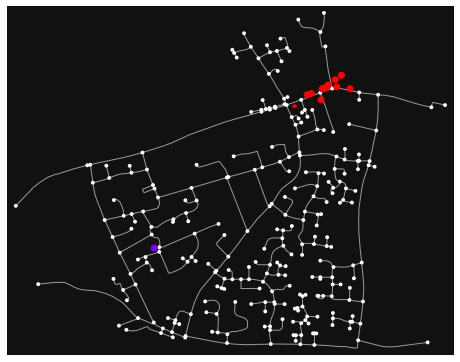

In [14]:
# plot the graph with shops overlaid
fig, ax = ox.plot_graph(G_un, show=False, close=False)
pois.plot(ax=ax,
           column='node_cluster_id',
           cmap='rainbow',
           categorical=True)

## 2. Generating isochrones/pedsheds

### Identify the id of the town centre cluster

This is the id of the cluster that has the greatest number of POIs associated with it

In [15]:
# identify the town centre by getting the cluster id associated with most POIs
town_centre_cluster = pois['node_cluster_id'].value_counts().index[0]

# in the case where where there are more outliers than pois in the largest cluster
if town_centre_cluster == -1:
    # select the second result (i.e. not the cluster labled as -1)
    town_centre_cluster = pois['node_cluster_id'].value_counts().index[1]

# this is the cluster id of the cluster with the most POIs in it
town_centre_cluster

0

### Identify the node at the centre of each cluster

***This works for small networks, but doesn't seem to scale well***

- The cluster ids that are returned are 0 and above for clusters and -1 for individual outliers.
- In this case we will treat the individual outliers as cluster centres as they represent convenience stores.
- We will also identify a single node at the centre of larger clusters to use for generating the isochrones.

In [16]:
central_node_cluster_id = dict()

for cluster_id in pois['node_cluster_id'].unique():

    # if the cluster id is -1 it is an isolated outlier which we will treat as a destination
    if cluster_id == -1:
        # add the node ids for all of the isolated outliers to the dictionary
        central_node_cluster_id.update({k:-1 for k in pois.loc[pois['node_cluster_id'] == -1, 'nearest_node'].values})
        
    # for the larger clusters we use the closeness centrality of the steiner tree to identify the centre node
    else:
        # get a list of nodes in the cluster
        nodes_in_cluster = node_clusters[node_clusters==cluster_id].index.to_list()
        
        # get the steiner tree for the nodes in the cluster
        G_st = approx.steiner_tree(G_un, nodes_in_cluster, weight='length')

        # calculate the closeness centrality values for the steiner tree
        d_ = nx.closeness_centrality(G_st)

        # get the key for node with the maximum closeness centrality value
        max_key = max(d_, key=d_.get)

        central_node_cluster_id.update({max_key: cluster_id})
        
central_node_cluster_id

{12637580: 0, 635943940: -1}

### Add travel times to nodes and get colors to match time bands

In [17]:
travel_speed = 4.5 #walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute

# add an edge attribute for time in minutes required to traverse each edge
for u, v, data in G_un.edges(data=True):
    data['time'] = data['length'] / meters_per_minute

In [18]:
# trip_times = [0, 2.5, 5, 7.5, 10, 12.5, 15] #in minutes
trip_times = [0, 2.5, 5, 7.5, 10, 12.5, 15] #in minutes

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='inferno_r', start=0, return_hex=True)
iso_colors

['#fcffa4', '#fbb61a', '#ed6925', '#ba3655', '#781c6d', '#320a5e', '#000004']

In [19]:
# color the nodes according to isochrone then plot the street network

# create a dictionary to hold node ids and colours
# for the town centre
tc_node_colors = {}
# for all centres
ac_node_colors = {}

# loop through the time bands specified, starting with the largest
# as the shorter times are calculated they will overwrite the colors from the longer times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    # loop through the various centres identified
    for center_node in central_node_cluster_id:
        # exctract the ego_graph for each centre and time as a subgraph
        subgraph = nx.ego_graph(G_un, center_node, radius=trip_time, distance='time')
        # color the nodes in that subgraph according to the node_colors dictionary
        for node in subgraph.nodes():
            # highlight the centre itself as red
            if trip_time == 0:
                ac_node_colors[node] = 'k'
                if central_node_cluster_id[center_node] == town_centre_cluster:
                    tc_node_colors[node] = 'k'
                    ac_node_colors[node] = 'k'
            # color the other nodes according to time from the centre
            else:
                ac_node_colors[node] = color
                if central_node_cluster_id[center_node] == town_centre_cluster:
                    tc_node_colors[node] = color

### Project geometries to web mercator for plotting with contextily web maps

In [20]:
study_boundary_prj = study_boundary.to_crs(epsg=3857)
pois_prj = pois.to_crs(epsg=3857)
buildings_prj = buildings.to_crs(epsg=3857)
G_un_prj = ox.project_graph(G_un, to_crs='epsg:3857')
GDF_un_nodes_prj, GDF_un_edges_prj = ox.graph_to_gdfs(G_un_prj)

In [21]:
buildings_prj['tc_colors'] = buildings_prj['nearest_node'].map(tc_node_colors)
buildings_prj['tc_colors'].fillna('gainsboro',inplace=True)

### Plotting

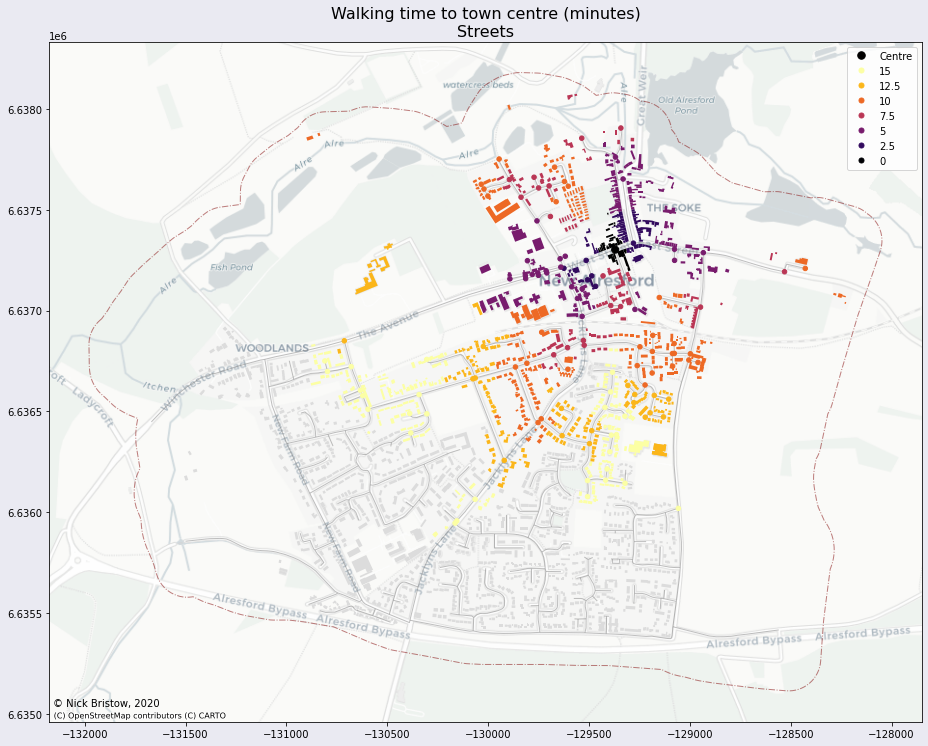

In [22]:
# create a list with the color of each node in order
nc = [tc_node_colors[node] if node in tc_node_colors else 'none' for node in G_un.nodes()]

# set node size
ns = [50 if c == 'k' else 20 if c != 'none' else 0 for c in nc]

### PLOT ###

fig, ax = plt.subplots(figsize=(13,13))
fig.set_facecolor('#EAEAF2')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot titles
ax.set_title(label='Walking time to town centre (minutes)\nStreets',
             fontdict={'fontsize':16,
                      }
            )
study_boundary_prj.plot(ax=ax,
                        alpha=0.5,
                        facecolor='none',
                        edgecolor='maroon',
                        linewidth=1,
                        linestyle='-.',
)

GDF_un_edges_prj.plot(ax=ax,
                      color='grey',
                      linewidth=1,
                      alpha=0.5,
                      zorder=2,
)
GDF_un_nodes_prj.plot(ax=ax,
                      c=nc,
                      markersize=ns,
                      zorder=3,
                      legend=True,
)
buildings_prj.plot(ax=ax,
                   color=buildings_prj['tc_colors'],
                   zorder=3)
cx.add_basemap(ax,
               zoom=15,
               source=cx.providers.CartoDB.Positron)

# add custom legend
legend_elements = [Line2D([0], [0], marker='o', color='k', label='Centre', markerfacecolor='k', markersize=7.5, linestyle='None')]

for time_,color_ in zip(sorted(trip_times, reverse=True), iso_colors):
    legend_elements.append(Line2D([0], [0], marker='o', color=color_, label=str(time_), markerfacecolor=color_, markersize=5, linestyle='None'))

ax.legend(handles=legend_elements)

ax.text(ax.get_xlim()[0]+20,
        ax.get_ylim()[0]+80,
        "© Nick Bristow, 2020")

# Save the file
fig.tight_layout()
fig.savefig('New_Alresford_Walking_time_to_town_centre.png', facecolor='#EAEAF2')

In [23]:
buildings_prj['ac_colors'] = buildings_prj['nearest_node'].map(ac_node_colors)
buildings_prj['ac_colors'].fillna('gainsboro',inplace=True)

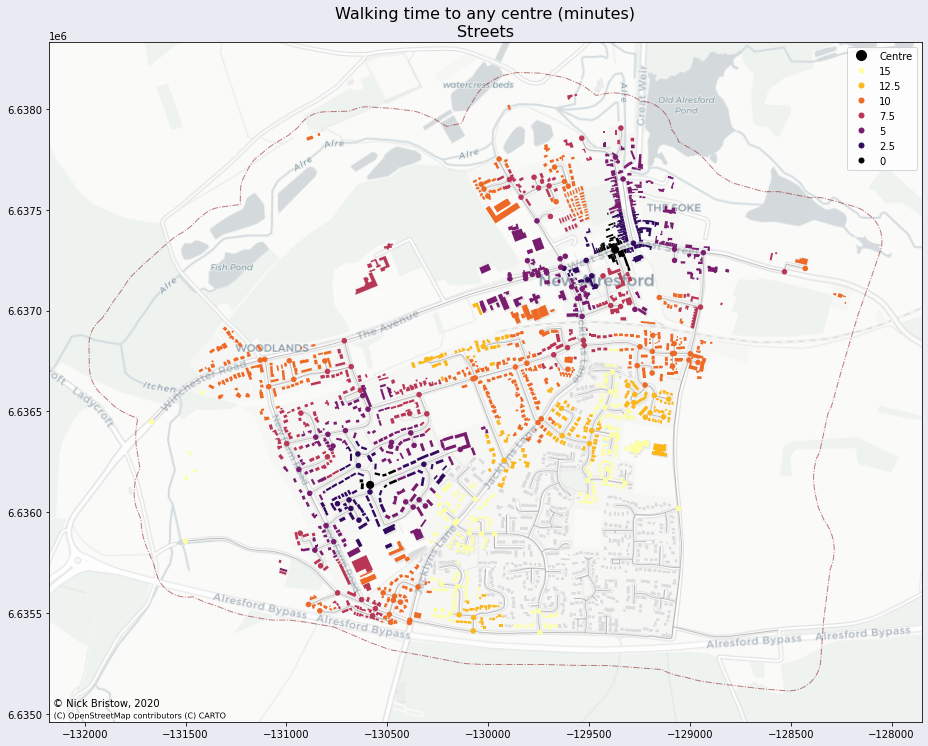

In [24]:
# create a list with the color of each node in order
nc = [ac_node_colors[node] if node in ac_node_colors else 'none' for node in G_un.nodes()]

# set node size
ns = [50 if c == 'k' else 20 if c != 'none' else 0 for c in nc]

### PLOT ###

fig, ax = plt.subplots(figsize=(13,13))
fig.set_facecolor('#EAEAF2')

# Plot titles
ax.set_title(label='Walking time to any centre (minutes)\nStreets',
             fontdict={'fontsize':16,
                      }
            )
study_boundary_prj.plot(ax=ax,
                        alpha=0.5,
                        facecolor='none',
                        edgecolor='maroon',
                        linewidth=1,
                        linestyle='-.',
)
GDF_un_edges_prj.plot(ax=ax,
                      color='grey',
                      linewidth=1,
                      alpha=0.5,
                      zorder=2,
)
GDF_un_nodes_prj.plot(ax=ax,
                      c=nc,
                      markersize=ns,
                      zorder=3,
                      legend=True,
)
buildings_prj.plot(ax=ax,
                   color=buildings_prj['ac_colors'],
                   zorder=3)
cx.add_basemap(ax,
               zoom=15,
               source=cx.providers.CartoDB.Positron)

# add custom legend
legend_elements = [Line2D([0], [0], marker='o', color='k', label='Centre', markerfacecolor='k', markersize=10, linestyle='None')]

for time_,color_ in zip(sorted(trip_times, reverse=True), iso_colors):
    legend_elements.append(Line2D([0], [0], marker='o', color=color_, label=str(time_), markerfacecolor=color_, markersize=5, linestyle='None'))

ax.legend(handles=legend_elements)

ax.text(ax.get_xlim()[0]+20,
        ax.get_ylim()[0]+80,
        "© Nick Bristow, 2020")
# Save the file
fig.tight_layout()
fig.savefig('New_Alresford_Walking_time_to_any_centre.png', facecolor='#EAEAF2')